In [1]:
# miscallenious
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))
from tqdm import tqdm_notebook as tqdm
from os.path import join
from os import listdir
import os

# basics
import pandas as pd
import numpy as np
import scipy
from numpy import linalg

# datasets
from sklearn.datasets import make_classification

# models
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.mixture import GaussianMixture as GM
from sklearn.feature_selection import VarianceThreshold

# metrics
from sklearn.metrics import roc_auc_score as roc_auc_score
from sklearn.metrics import roc_curve

# for CV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# for plots
import matplotlib
import matplotlib.pyplot as plt
BLUE = '#3CBEC5'
RED = '#EF758A'
GREEN = '#19B278'
ORANGE = '#F7A852'
GREY = '#A3A3A3'

# hiding code
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Instant Gratification Solution

I entered the Instant Gratification competition when it was 16 days to go, so there was already a lot of important information available in Kernels and Discussions. Shortly, in the Instant-Gratification competition we deal with a dataset of the following structure:
    
- [Data seemed to be generated by groups](https://www.kaggle.com/c/instant-gratification/discussion/92930#latest-541375) corresponding to the column **wheezy-copper-turtle-magic**, which means that we have 512 independent datasets of the size approximately 512 by 255 for training our models.

- Out of 255 features [only features with high variance supposed to be important](https://www.kaggle.com/fchmiel/low-variance-features-useless/). The number of important features varies from 33 to 47.

- [QDA proved to be a good modeling approach](https://www.kaggle.com/speedwagon/quadratic-discriminant-analysis) for this case and can give AUC of 0.966. 

- This high quality can be explained by the fact that the [data probably was generated with make_classification function](https://www.kaggle.com/mhviraf/synthetic-data-for-next-instant-gratification).

Knowing that let's look closer at what make_classification function does. This function has the following parameters:

- n_samples: The number of samples.
- n_features: The total number of features.
- n_informative: The number of informative features.
- n_redundant: The number of redundant features, linear combinations of informative features.
- n_repeated: The number of duplicated features.
- n_classes: The number of classes.
- n\_clusters\_per_class: The number of clusters per class.
- weights: The proportions of samples assigned to each class.
- flip_y: The fraction of samples whose class are randomly exchanged.
- class_sep: Larger values spread out the clusters/classes and make the classification task easier.
- hypercube: Parameter corresponding to the placement of the cluster centroids.
- shift: Shift of the feature values.
- scale: Scaling of the features by the specified value.
- shuffle: Shuffling the samples and the features.
- random_state: Random state.

So, I invite you to follow the sequence of my thoughts.

***

### Step 1. Size and features (first 6 parameters of make_classification function).

From the data structure (512 groups and 255 variables) and size (262144 = 512 * 512), we can assume that **n_features=255** and **n_samples=1024** were taken to generate both training and test data sets (both private and public).

Now, let's talk about features. First of all, repeated features are exact copies of important features, and because we don't see such columns in competition data we'll set **n_repeated=0**. Let's generate data set with make_classification function and following parameters:

~~~~
fake_data = make_classification(
    n_samples=1024, 
    n_features=255, 
    n_informative=30, 
    n_redundant=30, 
    n_repeated=0, 
    n_classes=2, 
    shuffle=False)
~~~~

By setting shuffle=False, I force first 30 columns to be informative, next 30 to be redundant and others to be just noise. By doing it 1000 times lets look at the distribution of the standard deviation of the informative, redundant and random features.

In [2]:
redundant_std = []
important_std = []
noise_std = []

for i in range(1000):
    fake_data = make_classification(n_samples=1024, n_features=255, 
                                    n_informative=30, n_redundant=30,
                                    n_repeated=0, n_classes=2, shuffle=False)
    important_std.append(fake_data[0][:, :30].std(axis=0))
    redundant_std.append(fake_data[0][:, 30:60].std(axis=0))
    noise_std.append(fake_data[0][:, 60:].std(axis=0))

redundant_std = np.concatenate(redundant_std)
important_std = np.concatenate(important_std)
noise_std = np.concatenate(noise_std)

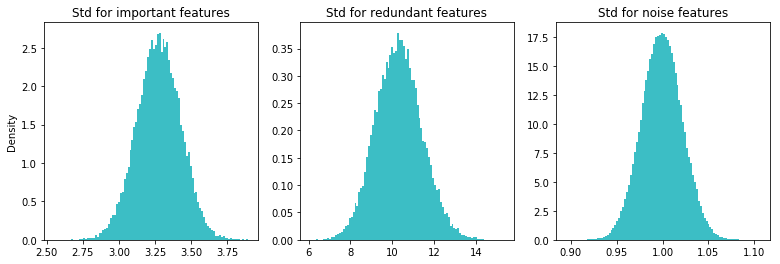

In [3]:
plt.subplots(figsize=(13,4))

plt.subplot(1,3,1)
plt.title('Std for important features')
plt.hist(important_std, bins=100, color=BLUE, density=1)
plt.ylabel('Density')

plt.subplot(1,3,2)
plt.title('Std for redundant features')
plt.hist(redundant_std, bins=100, color=BLUE, density=1)

plt.subplot(1,3,3)
plt.title('Std for noise features')
plt.hist(noise_std, bins=100, color=BLUE, density=1)

plt.show()

We see clear difference in standard deviation for informative, redundant and random features, that's why selecting important features with 1.5 threshold works so well. Moreover, there are no features in the competition data that have std bigger than 5, which leads us to an assumption that **n_redundant=0**

Number of important features ranges from 33 to 47, so **n_informative** $\in$ **{33,...,47}**. Number of classes is obviously **n_classes=2**. 

***

### Step 2. Shift, Scale and randomness (last 4 parameters of make_classification function).

Because mean and standard deviation for random columns are 0 and 1 respectively, we can assume that shift and scale were set to default **shift=0**, **scale=1**. On top of that, standard deviation for important columns also look the same for competition data and for data that we've just generated. So it's a pretty promising assumption and we can go further. Parameters **shuffle** and **random_state** are not so important, because they not change the nature of the data set.

***

### Step 3. Most interesting parameters.

Parameters **n_clusters_per_class, weights, class_sep, hypercube** are the ones that we are not very sure about, especially **n_clusters_per_class**. Weights look to be the same, because target seemed to be balanced. What makes it imposible to get 100% accurate model is that **flip_y>0**, and we can not predict this random factor in any case. However, what we can try is to build a model that can perfectly predict when **flip_y=0** and leave the rest for the luck.

QDA shown to be a very good approach, but let me show you the case when it's working not so good.

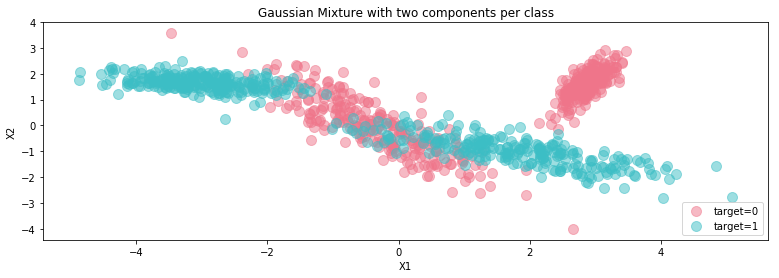

In [4]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, 
                           n_classes=2, n_clusters_per_class=2, flip_y=0.0, class_sep=4,
                           hypercube=False, random_state=7, shuffle=False)
y[500:] = 1 - y[500:]
plt.figure(figsize=(13,4))
plt.title('Gaussian Mixture with two components per class')
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], color=RED, s=100, alpha=0.5, label='target=0')
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], color=BLUE, s=100,  alpha=0.5, label='target=1')

plt.legend(loc=4)
plt.ylabel('X2')
plt.xlabel('X1')
plt.show()

Data set was generated with make_classification:

~~~~
make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, 
    n_classes=2, n_clusters_per_class=2, flip_y=0.0, class_sep=5,
    random_state=7, shuffle=False
)
~~~~

Now, lets look how QDA algorithm can hadle it:

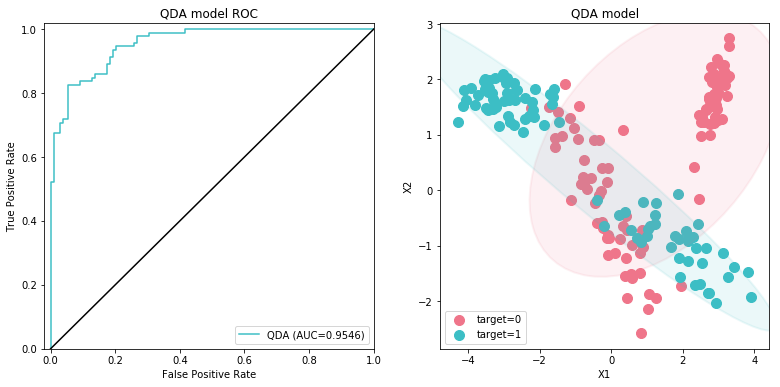

In [5]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# learn qda model
np.random.seed(0)
model = QDA(store_covariance=True)
model.fit(X_train, y_train)

# predict
preds = model.predict_proba(X_test)[:, 1]

# plot roc-curve
plt.subplots(figsize=(13,6))
plt.subplot(1,2,1)
plt.title('QDA model ROC')
fpr, tpr, threshold = roc_curve(y_test, preds)
score = roc_auc_score(y_test, preds)
plt.plot(fpr, tpr, color=BLUE, label='QDA (AUC={})'.format(np.round(score, 4)))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color='black')
plt.xlim([-0.02, 1.])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plot model
splot = plt.subplot(1,2,2)
plt.title('QDA model')
plt.scatter(X_test[:, 0][y_test == 0], X_test[:, 1][y_test == 0],
            color=RED, s=100, label='target=0')
plt.scatter(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1],
            color=BLUE, s=100, label='target=1')

# plot red elipse
mean = model.means_[0]
cov = model.covariance_[0]
v, w = linalg.eigh(cov)
u = w[0] / linalg.norm(w[0])
angle = np.arctan(u[1] / u[0])
angle = 180 * angle / np.pi
# filled Gaussian at 2 standard deviation
ell = matplotlib.patches.Ellipse(mean, 4*v[0]**0.5, 4*v[1]**0.5, 
                                 180+angle, edgecolor=RED,
                                 linewidth=2, facecolor=RED)
ell.set_clip_box(splot.bbox)
ell.set_alpha(0.1)
splot.add_patch(ell)
# plot blue elipse
mean = model.means_[1]
cov = model.covariance_[1]
v, w = linalg.eigh(cov)
u = w[0] / linalg.norm(w[0])
angle = np.arctan(u[1] / u[0])
angle = 180 * angle / np.pi
# filled Gaussian at 2 standard deviation
ell = matplotlib.patches.Ellipse(mean, 4*v[0]**0.5, 4*v[1]**0.5, 
                                 180+angle, edgecolor=BLUE, 
                                 linewidth=2, facecolor=BLUE)
ell.set_clip_box(splot.bbox)
ell.set_alpha(0.1)
splot.add_patch(ell)


plt.legend(loc=3)
plt.ylabel('X2')
plt.xlabel('X1')
plt.show()

Pretty good, however, we see that it doesn't see this structure of four clusters in the data. From make_classification documentation one can find that these clusters are gaussian components, so the best way to find them is to apply Gaussian Mixture model. 

_Note: Gaussian Mixture model will only give you clusters, you need to bind these clusters to one of the classes 0 or 1. That you can do by looking at the proportion of the certain class in each cluster and assigning cluster to the dominant class._

Lets look how GMM algorithm performed at this data:

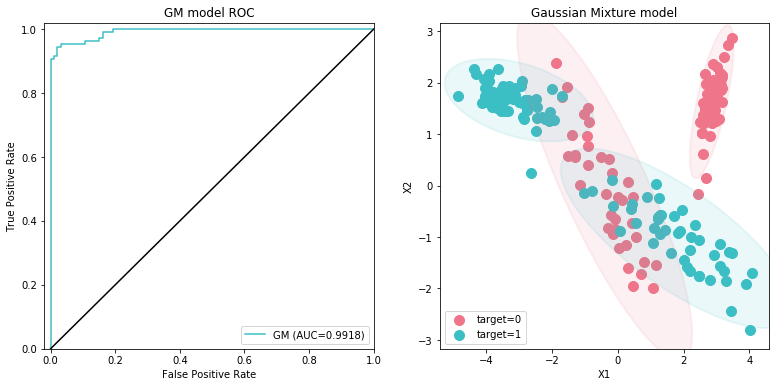

In [6]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# learn gm model
model = GM(n_components=4, random_state=0)
model.fit(X)

# define classes
res = pd.DataFrame(data=model.predict(X_train), columns=['cluster'])
res['target'] = y_train
res = res.groupby('cluster')['target'].mean()
ones_indices = []
zeros_indices = []
for j in range(len(res)):
    if res[j] > 0.5:
        ones_indices.append(j)
    else:
        zeros_indices.append(j)

# predict
preds = model.predict_proba(X_test)[:, ones_indices].sum(axis=1)

# plot roc-curve
plt.subplots(figsize=(13,6))
plt.subplot(1,2,1)
plt.title('GM model ROC')
fpr, tpr, threshold = roc_curve(y_test, preds)
score = roc_auc_score(y_test, preds)
plt.plot(fpr, tpr, color=BLUE, label='GM (AUC={})'.format(np.round(score, 4)))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color='black')
plt.xlim([-0.02, 1.])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plot model
splot = plt.subplot(1,2,2)
plt.title('Gaussian Mixture model')
plt.scatter(X_test[:, 0][y_test == 0], X_test[:, 1][y_test == 0],
            color=RED, s=100, label='target=0')
plt.scatter(X_test[:, 0][y_test == 1], X_test[:, 1][y_test == 1],
            color=BLUE, s=100, label='target=1')

# plot red elipse
for i in zeros_indices:
    mean = model.means_[i]
    cov = model.covariances_[i]
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi
    # filled Gaussian at 2 standard deviation
    ell = matplotlib.patches.Ellipse(mean, 6*v[0]**0.5, 6*v[1]**0.5, 
                                     180+angle, edgecolor=RED,
                                     linewidth=2, facecolor=RED)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.1)
    splot.add_patch(ell)
# plot blue elipse
for i in ones_indices:
    mean = model.means_[i]
    cov = model.covariances_[i]
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi
    # filled Gaussian at 2 standard deviation
    ell = matplotlib.patches.Ellipse(mean, 6*v[0]**0.5, 6*v[1]**0.5, 
                                     180+angle, edgecolor=BLUE, 
                                     linewidth=2, facecolor=BLUE)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.1)
    splot.add_patch(ell)


plt.legend(loc=3)
plt.ylabel('X2')
plt.xlabel('X1')
plt.show()

Nearly perfect! Let's move to the step 4.

### Step 4. Effect of flipping the target

Knowing that we can build nearly the best classifier, what is the effect of flipping the target? Suppose that your classes are perfectly separable and you can assign probabilities that will lead to a perfect AUC. Let's see an example of 10000 points, 5000 in each class:

$$Classes = \{0, 0, ..., 0, 1,..., 1, 1\}$$
$$Predictions = \{0.000, 0.001, ..., 0.998, 0.999\}$$

Lets flip the target value for 2.5% (250) of the points (1) in the middle, (2) on the sides, (3) randomly, and look at the AUC:

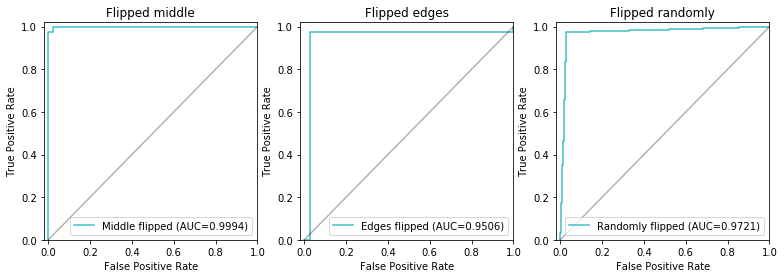

In [7]:
np.random.seed(0)
# Perfect prediction
preds = np.arange(10000)/10000
# Original target
target = np.concatenate([np.zeros(5000), np.ones(5000)])
# Flipped middle
target_middle_flipped = target.copy()
target_middle_flipped[5000-125:5000+125] = 1 - target_middle_flipped[5000-125:5000+125]
# Flipped edges
target_edges_flipped = target.copy()
target_edges_flipped[:125] = 1 - target_edges_flipped[:125]
target_edges_flipped[-125:] = 1 - target_edges_flipped[-125:]
# Flipped randomly
target_randomly_flipped = target.copy()
index = np.random.rand(10000) < 0.025
target_randomly_flipped[index] = 1 - target_randomly_flipped[index]

plt.subplots(figsize=(13,4))
# plot roc-curve
plt.subplot(1,3,1)
plt.title('Flipped middle')
fpr, tpr, threshold = roc_curve(target_middle_flipped, preds)
score = roc_auc_score(target_middle_flipped, preds)
plt.plot(fpr, tpr, color=BLUE, label='Middle flipped (AUC={})'.format(np.round(score, 4)))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color='black', alpha=0.3)
plt.xlim([-0.02, 1.])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# plot roc-curve
plt.subplot(1,3,2)
plt.title('Flipped edges')
fpr, tpr, threshold = roc_curve(target_edges_flipped, preds)
score = roc_auc_score(target_edges_flipped, preds)
plt.plot(fpr, tpr, color=BLUE, label='Edges flipped (AUC={})'.format(np.round(score, 4)))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color='black', alpha=0.3)
plt.xlim([-0.02, 1.])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# plot roc-curve
plt.subplot(1,3,3)
plt.title('Flipped randomly')
fpr, tpr, threshold = roc_curve(target_randomly_flipped, preds)
score = roc_auc_score(target_randomly_flipped, preds)
plt.plot(fpr, tpr, color=BLUE, label='Randomly flipped (AUC={})'.format(np.round(score, 4)))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], color='black', alpha=0.3)
plt.xlim([-0.02, 1.])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


plt.show()

We see that the impact from flips can drammatically change the result. However, let's face two facts:

1. We can not predict this randomness.
2. We can assume that the flips are evenly spread across our predictions.

Let's also look at the distribution of AUC for randomly flipped target.

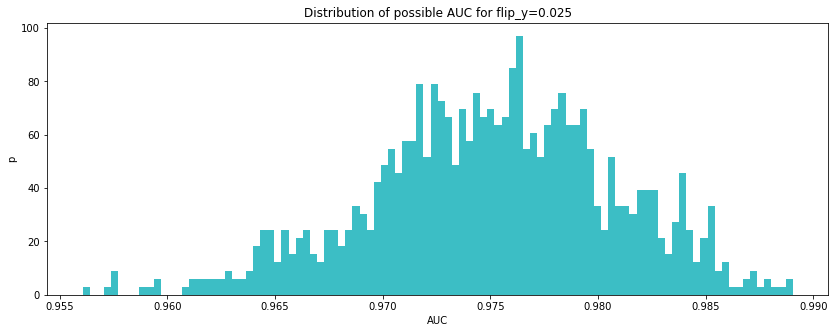

In [8]:
scores = []
for i in range(1000):
    np.random.seed(i)
    # Perfect prediction
    preds = np.arange(1000)/1000
    # Original target
    target = np.concatenate([np.zeros(500), np.ones(500)])
    # Flipped randomly
    target_randomly_flipped = target.copy()
    index = np.random.rand(1000) < 0.025
    target_randomly_flipped[index] = 1 - target_randomly_flipped[index]
    # Evaluate AUC
    score = roc_auc_score(target_randomly_flipped, preds)
    scores.append(score)

plt.figure(figsize=(14,5))
plt.title("Distribution of possible AUC for flip_y=0.025")
plt.hist(scores, bins=100, density=1, color=BLUE)
plt.ylabel('p')
plt.xlabel('AUC')
plt.show()

It means that results on unseen data can deviate by more than 0.005 in AUC even for the perfect model. So our strategy will be not to find the parameters to raise on the LB of the competition, but to find the parameters that can perfectly predict target for most of the data set.

***

### Step 5. Experiments with synthetic data

How we can build a model that perfectly predicts data and not overfit to it? Because we have a strong hypothesis on how data was created we can tune model parameters such that it will predict perfectly for most of the synthetically generated data sets. Not showing competition to it will save us from overfitting.

We will be generating a data set of the same structure as the competition data:

- **n_samples=768**, 512 for training and 256 for test
- **n_features=255**
- **n_important=33**
- **n_clusters_per_class=3**
- by variating **weights**, we will change the propotion of the dominant class from 0.5 to 0.6
- **flip=0** to experiment if GM model can be completely correct
- **class_sep** will be a random number between 0.9 and 1
- **hypercube** will be chosen randomly between True and False

Next thing to do is to generate hundreds of such data sets and optimize parameters of the GMM.

For the first attempt we'll set the parameter n_components in the GMM to 6, because we know that there will be 3 clusters per each of the 2 classes, and do the modelling with other parameters set to default. Let's look at the minimum, maximum and mean score that we can get for 100 different data sets:

In [9]:
def get_data(random_state, n_features, n_samples=512+256, flip=0, n_clusters_per_class=3):
    np.random.seed(random_state)
    t = np.random.rand() / 10
    params = {
        "n_samples": n_samples,
        "n_features": n_features,
        "n_informative": n_features,
        "n_redundant": 0,
        "n_repeated": 0,
        "n_classes": 2,
        "n_clusters_per_class": n_clusters_per_class,
        "weights": [0.5+t, 0.5-t],
        "flip_y": flip,
        "class_sep": 1 - np.random.rand() / 10,
        "hypercube": np.random.rand() < 0.5,
        "shuffle": True,
        "random_state": random_state
    }

    _ = make_classification(**params)
    fake_data, y = pd.DataFrame(_[0], columns=["x{}".format(i) for i in range(n_features)]), _[1]
    fake_data['target'] = y

    fake_train = fake_data[:512].reset_index().drop('index', axis=1)     
    fake_test = fake_data[512:].reset_index().drop('index', axis=1)

    return fake_train, fake_test

def build_gmm_model(fake_train, fake_test, n_components=6):
    cols = list(fake_train.columns[:-1])
    # Joining train and test for GMM
    X = np.vstack([fake_train[cols], fake_test[cols]])
    # Building GMM
    gm = GM(n_components=n_components, random_state=0)
    gm.fit(X)
    # Defining clusters corresponding to target=1
    res = pd.DataFrame(data=gm.predict(fake_train[cols]), columns=['cluster'])
    res['target'] = fake_train['target'].values
    res = res.groupby('cluster')['target'].mean()
    ones_indices = []
    for j in range(len(res)):
        if res[j] > 0.5:
            ones_indices.append(j)
    # Making predictions
    preds = gm.predict_proba(fake_test[cols])[:, ones_indices].sum(axis=1)
    return roc_auc_score(fake_test['target'], preds)

In [10]:
score = []
for i in range(100):
    fake_train, fake_test = get_data(i, n_features=33)
    score.append(build_gmm_model(fake_train, fake_test, n_components=6))
print("Min score = ", np.min(score))
print("Mean score = ", np.mean(score))
print("Max score = ", np.max(score))

Min score =  0.44783168741949336
Mean score =  0.8159223370950822
Max score =  1.0


So, sometimes we even reached the perfect classifier. Let's try to optimize some of the GMM parameters. It has parameters n_init and init_params which means that GMM model will be run several times starting from random initializations and then it selects the best iteration. Let's try to set n_init to 20 and init_params to random.

In [11]:
def build_gmm_model(fake_train, fake_test, n_components=6, n_init=20):
    cols = list(fake_train.columns[:-1])
    # Joining train and test for GMM
    X = np.vstack([fake_train[cols], fake_test[cols]])
    # Building GMM
    gm = GM(n_components=n_components, n_init=n_init, 
            random_state=0, init_params='random')
    gm.fit(X)
    # Defining clusters corresponding to target=1
    res = pd.DataFrame(data=gm.predict(fake_train[cols]), columns=['cluster'])
    res['target'] = fake_train['target'].values
    res = res.groupby('cluster')['target'].mean()
    ones_indices = []
    for j in range(len(res)):
        if res[j] > 0.5:
            ones_indices.append(j)
    # Making predictions
    preds = gm.predict_proba(fake_test[cols])[:, ones_indices].sum(axis=1)
    return roc_auc_score(fake_test['target'], preds)

In [12]:
score = []
for i in range(100):
    fake_train, fake_test = get_data(i, n_features=33)
    score.append(build_gmm_model(fake_train, fake_test, n_components=6))
print("Min score = ", np.min(score))
print("Mean score = ", np.mean(score))
print("Max score = ", np.max(score))

Min score =  1.0
Mean score =  1.0
Max score =  1.0


Now it's perfect! Let's try it for more than 33 features:

In [13]:
score = []
for i in range(100):
    fake_train, fake_test = get_data(i, n_features=47)
    score.append(build_gmm_model(fake_train, fake_test, n_components=6))
print("Min score = ", np.min(score))
print("Mean score = ", np.mean(score))
print("Max score = ", np.max(score))

Min score =  0.562083024462565
Mean score =  0.7917138432059158
Max score =  1.0


For 47 features it worked not so well. The secret sauce is the regularization of the covariance matrix. Let's look at the model quality for different values of reg_covar:

In [14]:
def build_gmm_model(fake_train, fake_test, n_components=6, n_init=20, reg_covar=0.5):
    cols = list(fake_train.columns[:-1])
    # Joining train and test for GMM
    X = np.vstack([fake_train[cols], fake_test[cols]])
    # Building GMM
    gm = GM(n_components=n_components, n_init=n_init, 
            random_state=0, init_params='random', reg_covar=reg_covar)
    gm.fit(X)
    # Defining clusters corresponding to target=1
    res = pd.DataFrame(data=gm.predict(fake_train[cols]), columns=['cluster'])
    res['target'] = fake_train['target'].values
    res = res.groupby('cluster')['target'].mean()
    ones_indices = []
    for j in range(len(res)):
        if res[j] > 0.5:
            ones_indices.append(j)
    # Making predictions
    preds = gm.predict_proba(fake_test[cols])[:, ones_indices].sum(axis=1)
    return roc_auc_score(fake_test['target'], preds)

In [15]:
for reg_covar in [1, 5, 10]:
    score = []
    for i in range(100):
        fake_train, fake_test = get_data(i, n_features=47)
        score.append(build_gmm_model(fake_train, fake_test, n_components=6, reg_covar=reg_covar))
    print("reg_covar = {}: Min score = {}, Mean score = {}".format(reg_covar, np.min(score), np.mean(score)))

reg_covar = 1: Min score = 0.6936146721462308, Mean score = 0.8782139741161032
reg_covar = 5: Min score = 0.991250080422055, Mean score = 0.9998679217326921
reg_covar = 10: Min score = 0.9987766087594813, Mean score = 0.999945378120418


To tell you the short story, by a simple grid search for the best reg_covar parameter one can find that more features require larger reg_covar for better performance. By doing so you can find that the good parameters are:

- 33 features: 2.0,
- 34 features: 2.5,
- 35 features: 3.5,
- 36 features: 4.0,
- 37 features: 4.5,
- 38 features: 5.0,
- 39 features: 5.5,
- 40 features: 6.0,
- 41 features: 6.5,
- 42 features: 7.0,
- 43 features: 7.5,
- 44 features: 8.0,
- 45 features: 9,
- 46 features: 9.5,
- 47 features: 10.

### Important note: how do we know the number of clusters in advance?

We were building models in the assumption that there are 3 clusters per class, but how can we know it? Well, the answer is pretty simple, right choice of the n_components will give better results:

In [16]:
fake_train, fake_test = get_data(0, n_features=33, n_clusters_per_class=4)
auc = build_gmm_model(fake_train, fake_test, n_components=4, reg_covar=2)
print("#Clusters per class = {}, #Components of GMM = {}: AUC = {}".format(4, 4, auc))
auc = build_gmm_model(fake_train, fake_test, n_components=6, reg_covar=2)
print("#Clusters per class = {}, #Components of GMM = {}: AUC = {}".format(4, 6, auc))
auc = build_gmm_model(fake_train, fake_test, n_components=8, reg_covar=2)
print("#Clusters per class = {}, #Components of GMM = {}: AUC = {}".format(4, 8, auc))

#Clusters per class = 4, #Components of GMM = 4: AUC = 0.7170955882352941
#Clusters per class = 4, #Components of GMM = 6: AUC = 0.8263480392156862
#Clusters per class = 4, #Components of GMM = 8: AUC = 0.9587009803921569


In [17]:
fake_train, fake_test = get_data(0, n_features=33, n_clusters_per_class=3)
auc = build_gmm_model(fake_train, fake_test, n_components=4, reg_covar=2)
print("#Clusters per class = {}, #Components of GMM = {}: AUC = {}".format(3, 4, auc))
auc = build_gmm_model(fake_train, fake_test, n_components=6, reg_covar=2)
print("#Clusters per class = {}, #Components of GMM = {}: AUC = {}".format(3, 6, auc))
auc = build_gmm_model(fake_train, fake_test, n_components=8, reg_covar=2)
print("#Clusters per class = {}, #Components of GMM = {}: AUC = {}".format(3, 8, auc))

#Clusters per class = 3, #Components of GMM = 4: AUC = 0.7400829259236339
#Clusters per class = 3, #Components of GMM = 6: AUC = 1.0
#Clusters per class = 3, #Components of GMM = 8: AUC = 0.9844049755554181


In [18]:
fake_train, fake_test = get_data(0, n_features=33, n_clusters_per_class=2)
auc = build_gmm_model(fake_train, fake_test, n_components=4, reg_covar=2)
print("#Clusters per class = {}, #Components of GMM = {}: AUC = {}".format(2, 4, auc))
auc = build_gmm_model(fake_train, fake_test, n_components=6, reg_covar=2)
print("#Clusters per class = {}, #Components of GMM = {}: AUC = {}".format(2, 6, auc))
auc = build_gmm_model(fake_train, fake_test, n_components=8, reg_covar=2)
print("#Clusters per class = {}, #Components of GMM = {}: AUC = {}".format(2, 8, auc))

#Clusters per class = 2, #Components of GMM = 4: AUC = 1.0
#Clusters per class = 2, #Components of GMM = 6: AUC = 1.0
#Clusters per class = 2, #Components of GMM = 8: AUC = 0.9924635532493205


For me it seemed like for most of the groups the best option was taking 3 clusters per class, sometimes 2 was slightly better (but it might be the effect of the flipped target). I assumed that this parameter was set to 3 for all groups.